In [4]:
#%% Imports
import os
import shutil
import nibabel as nib
import numpy as np
import random
import pickle
from glob import glob
from scipy import ndimage
from nilearn.image import resample_to_img, resample_img
from nilearn.masking import compute_background_mask, compute_epi_mask
from nilearn.plotting import plot_roi, plot_epi

In [5]:
# Set working directory
os.chdir('/home/uziel/DISS')

In [11]:
# load prediction
root = './milestones_1/DM_V1_transfer_0/output/predictions/trainSession/predictions'
root_2 = './data/ISLES2017/training'

segms = sorted(glob(os.path.join(root, '*Segm.nii.gz')))
prob_maps_class0 = sorted(glob(os.path.join(root, '*ProbMapClass0.nii.gz')))
prob_maps_class1 = sorted(glob(os.path.join(root, '*ProbMapClass1.nii.gz')))
segms_img = []

# resize its prediction for final result validation
for i in range(len(segms)):
    # Find subject that contains the code in pred.
    subject = sorted([y
                      for x in os.walk(root_2)
                      for y in glob(os.path.join(x[0], '*'))
                      if segms[i].split('_')[-2] in y
                     ])[0].split('/')[-2]
    
    subject_channels = sorted([y
                               for x in os.walk(os.path.join(root_2, subject))
                               for y in glob(os.path.join(x[0], '*MR_*.nii'))
                               if '4DPWI' not in y
                              ])
    subject_label = sorted([y
                            for x in os.walk(os.path.join(root_2, subject))
                            for y in glob(os.path.join(x[0], '*OT*.nii'))
                           ])
    
    # Load ADC channel as reference
    original_img = nib.load(subject_channels[0])
    
    # load prediction
    pred = nib.load(segms[i])
    pmap_0 = nib.load(prob_maps_class0[i])
    pmap_1 = nib.load(prob_maps_class1[i])
    
    # Upsample to original size
    pred = resample_img(pred,
                        original_img.affine,
                        original_img.shape,
                        interpolation='nearest')
    pmap_0 = resample_img(pmap_0,
                          original_img.affine,
                          original_img.shape,
                          interpolation='continuous')
    pmap_1 = resample_img(pmap_1,
                          original_img.affine,
                          original_img.shape,
                          interpolation='continuous')

    segms_img.append([subject_channels, subject_label[0], pred, pmap_0, pmap_1])   

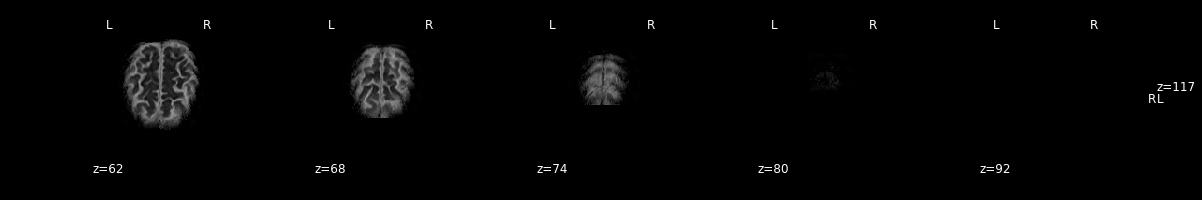

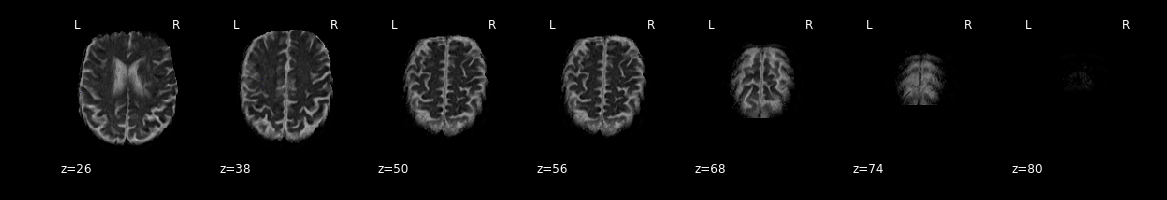

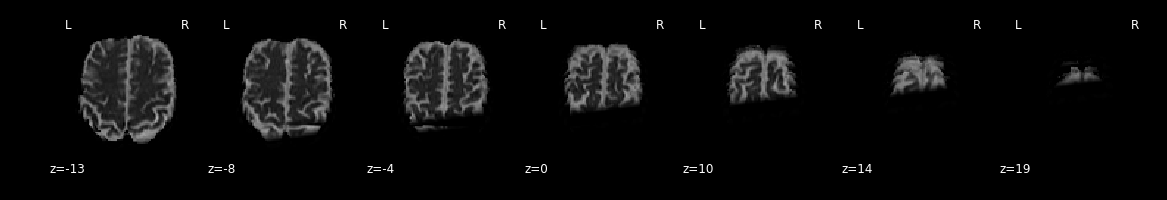

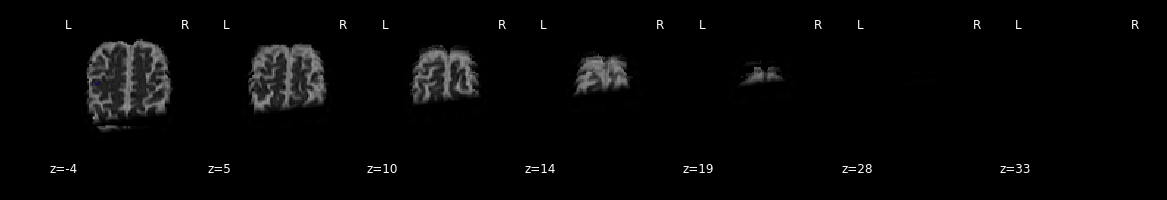

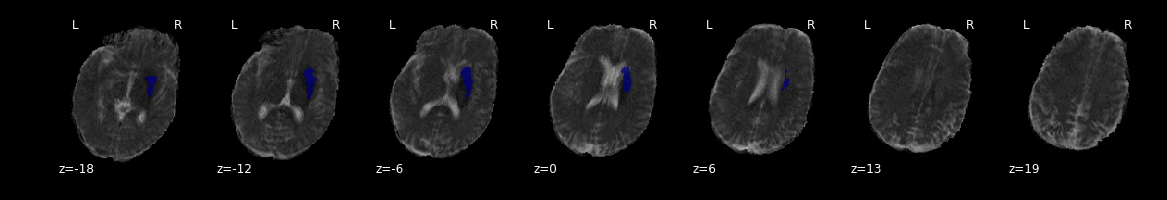

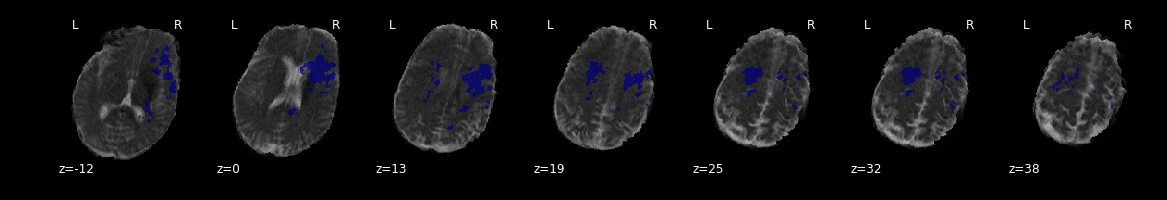

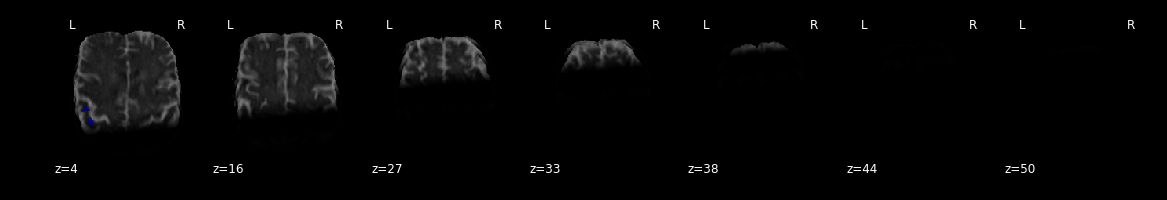

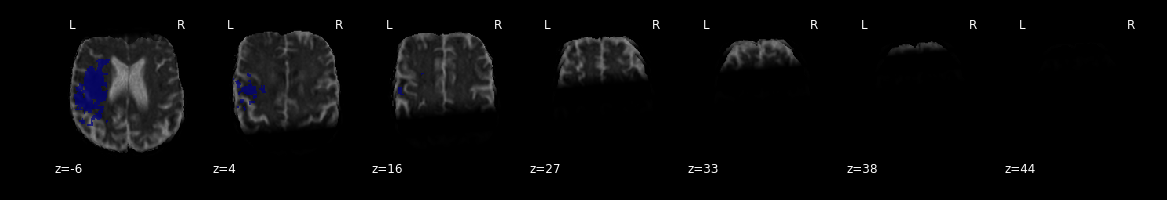

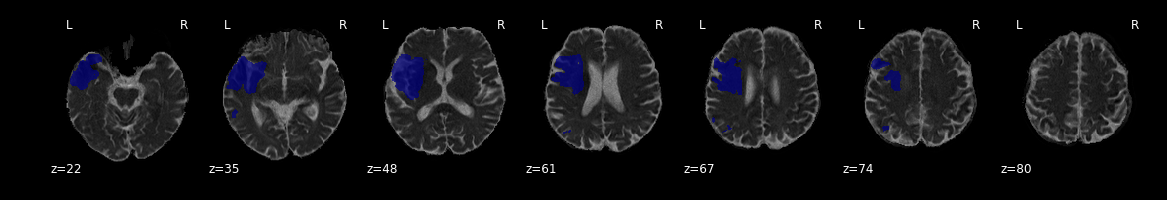

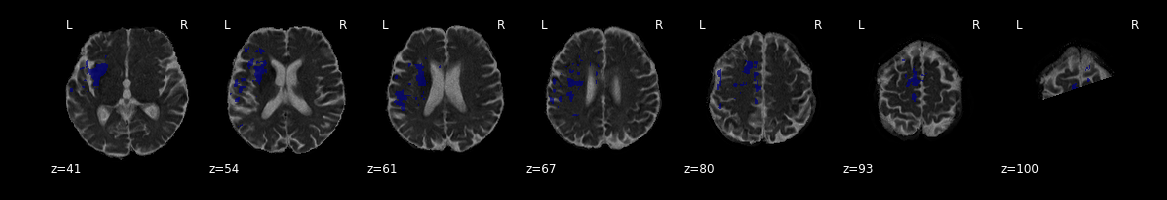

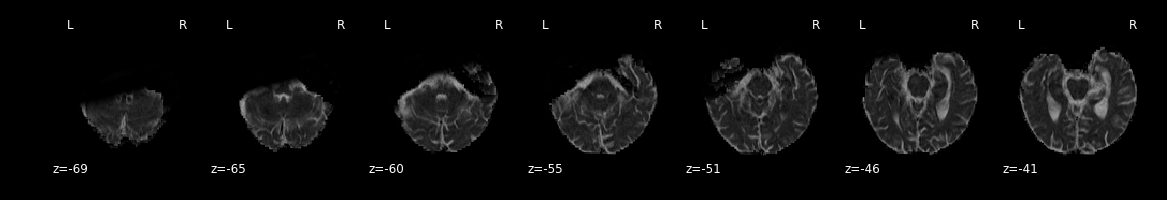

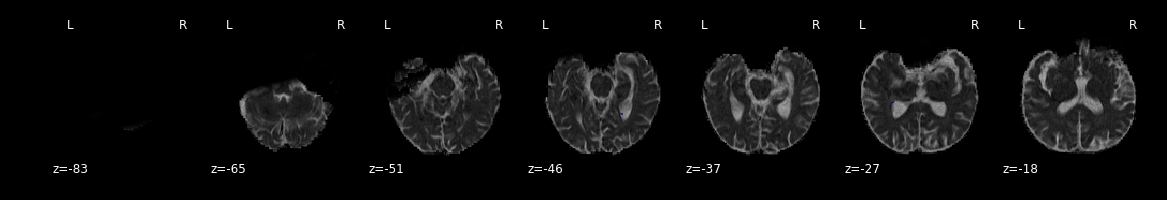

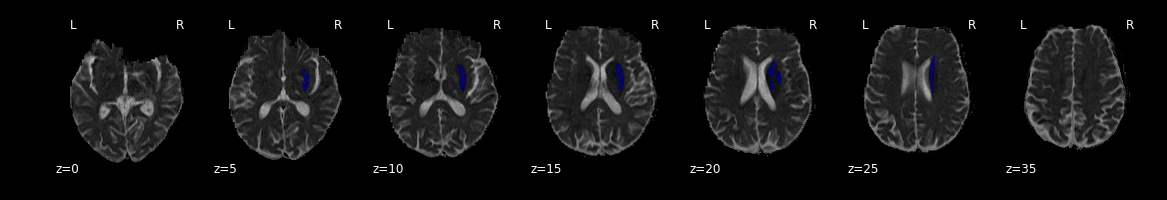

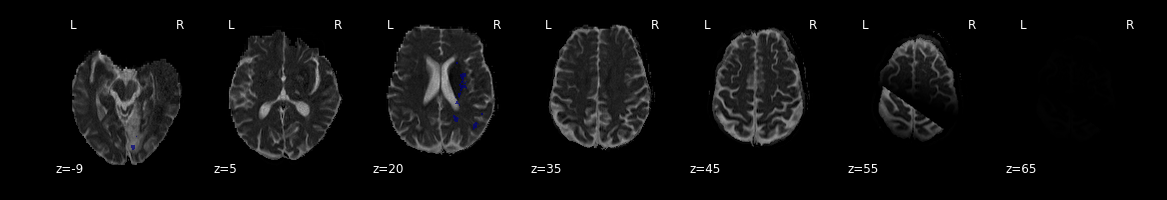

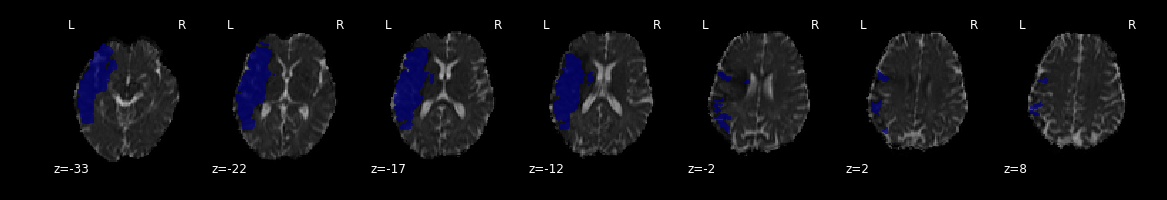

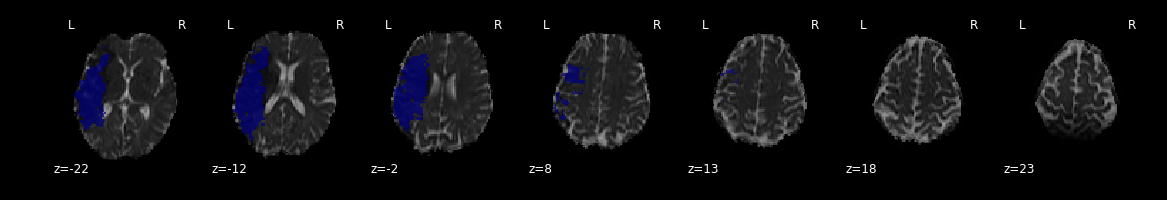

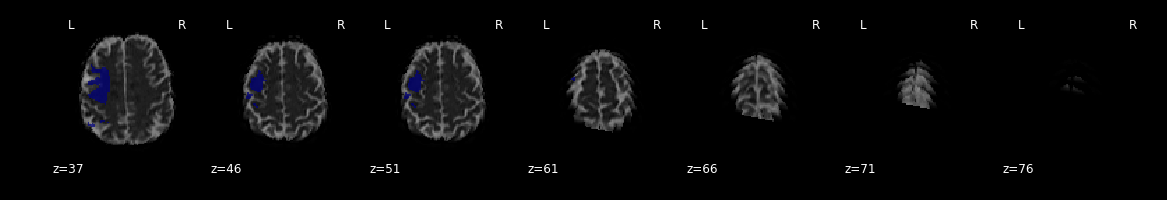

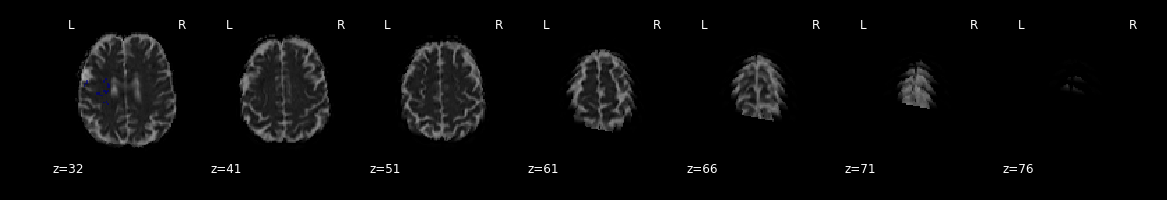

In [16]:
# Plot original label and predicted label on top of original image
for subject_channels, subject_label, pred, pmap_0, pmap_1 in segms_img:
    original_img = nib.load(subject_channels[0])
    label = nib.load(subject_label)

    plot_roi(label, original_img, display_mode='z')
    plot_roi(pred, original_img, display_mode='z')
    #plot_roi(pmap_1, original_img)
    #plot_roi(pmap_0, original_img)

In [30]:
root = "./milestones_1"
trained_models = sorted(glob(os.path.join(root, '*DM_V*[0-9]')))

for model in trained_models:
    # Plot and save training progress
    os.system("python ischleseg/deepmedic/plotSaveTrainingProgress.py " +
              os.path.join(model, "output/logs/trainSession.txt -d -m 20 -s"))
    # Move files to the corresponding model directory
    os.system("mv trainingProgress.pdf " + model)
    os.system("mv trainingProgress.pkl " + model)


In [31]:
# Load "measuredMetricsFromAllExperiments"
# 1st dimension: "Validation" (0), "Training" (1)
# 2nd dimension: ? (0)
# 3rd dimension: "Mean Accuracy" (0), "Sensitivity" (1), "Specificity" (2), "DSC (samples)" (3), "DSC (full-segm)" (4)

metrics = {}
for model in trained_models:
    with open(os.path.join(model, "trainingProgress.pkl"), 'rb') as input:
        metrics[os.path.basename(model)] = pickle.load(input)
        
# Use the metrics of all models to average results between same model variations
# DM_V0_{0..9}, DM_V0_transfer_{0..9}, DM_V1_{1..9}, DM_V1_transfer_{1..9}
